## Código original


In [15]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, err: list):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.err = err
        self.integral = 0.0
        self.last_error = 0.0
        self.time_init = True

    def calculate_control_action(self, setpoint, measured_value):
        error = setpoint - measured_value

        # Termo Proporcional
        P_term = self.Kp * error

        # Termo Integral (Anti-windup/Saturação não incluída, mas pode ser adicionada)
        if not self.time_init:
            self.integral += error * self.dt
            I_term = self.Ki * self.integral
        else:
            I_term = 0.0
            self.time_init = False

        # Termo Derivativo
        derivative = (error - self.last_error) / self.dt
        D_term = self.Kd * derivative

        self.last_error = error
        self.err.append(error)

        u = P_term + I_term + D_term
        return u

Rodando Benchmark Controlador Não-Linear...
Otimizando PID (Max Iter: 25)...
Iter 0: Melhor Custo = 0.004823
Iter 5: Melhor Custo = 0.001230
Iter 10: Melhor Custo = 0.000042
Iter 15: Melhor Custo = 0.000000


/tmp/ipython-input-1370018763.py:127: RuntimeWarning: overflow encountered in scalar add
  total_error_sq += (ref - current_tau)**2
/tmp/ipython-input-1370018763.py:127: RuntimeWarning: overflow encountered in scalar power
  total_error_sq += (ref - current_tau)**2
/tmp/ipython-input-1370018763.py:81: RuntimeWarning: overflow encountered in scalar multiply
  output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
/tmp/ipython-input-1370018763.py:122: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  out = odeint(motor_physics, current_tau, [0.0, dt], args=(u,))
/tmp/ipython-input-1370018763.py:122: ODEintWarning: Run terminated (internal error). Run with full_output = 1 to get quantitative information.
  out = odeint(motor_physics, current_tau, [0.0, dt], args=(u,))


Iter 20: Melhor Custo = 0.000000

PID Otimizado: Kp=1936.58, Ki=107.79, Kd=0.00

--- RESULTADOS FINAIS ---
Erro Quadrático Médio (Não-Linear): 0.016330
Erro Quadrático Médio (PID Otimizado): 0.000000
>> PID obteve melhor rastreamento.


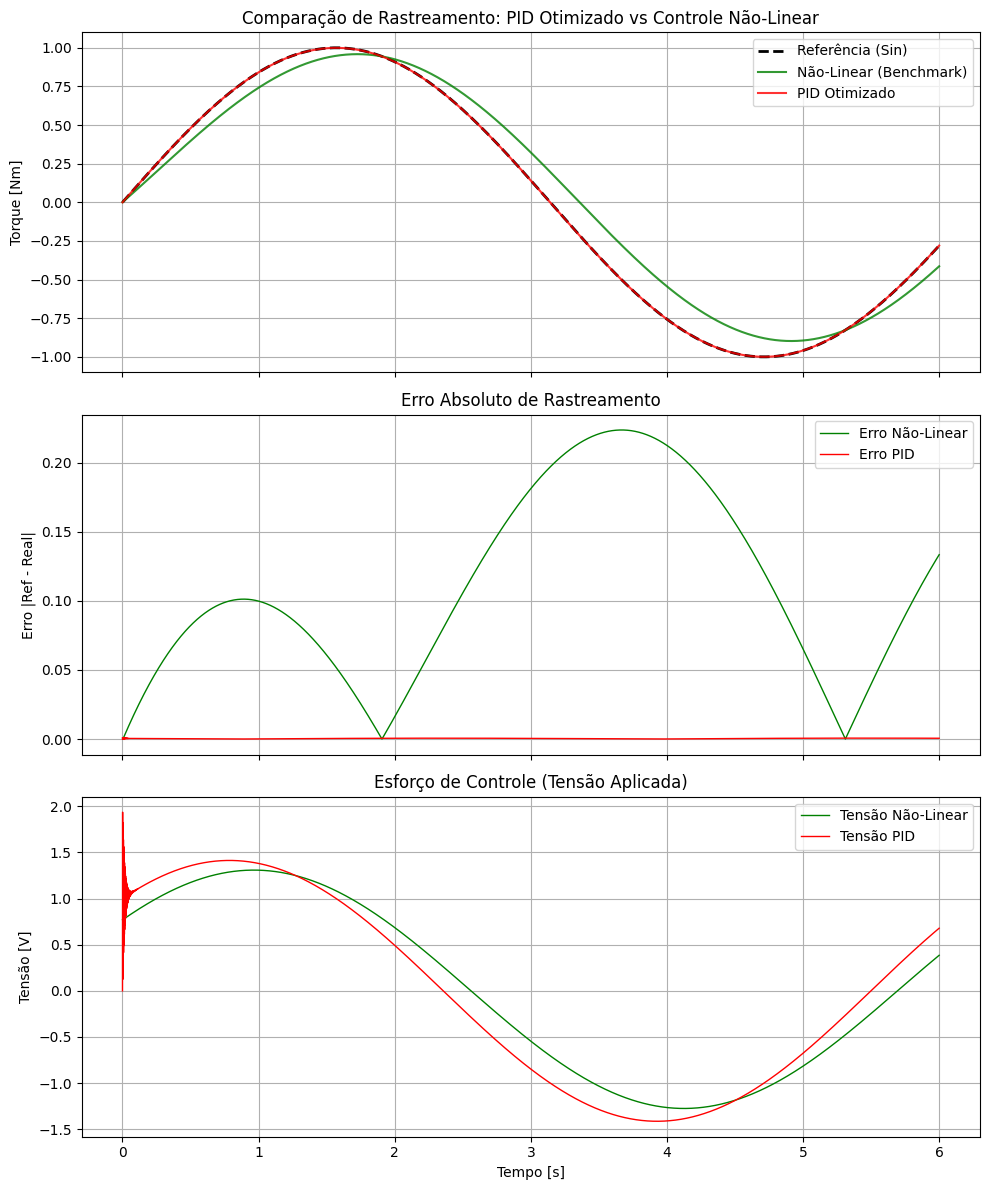

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
import pandas as pd

# --- PARÂMETROS GERAIS (Do seu código) ---
tf = 6.0
ts_ms = 1.0  # Ajustei para 1ms para a otimização não demorar horas (0.01 é muito fino para loop de otimização)
# Se quiser a precisão exata original, mude para 0.01, mas a otimização demorará.

# --- PARÂMETROS DO MOTOR & MODELO (Do seu código) ---
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3

# ==========================================
# 1. IMPLEMENTAÇÃO DO SEU CÓDIGO (BENCHMARK)
# ==========================================
def dc_motor_model_original(x1_m, u):
    # Modelo físico real (sem erro induzido nas equações, conforme seu código novo)
    dx1_m = -a*k*x1_m + k*u
    return dx1_m

def motor_controller_nonlinear(tau, tau_ref, taup_ref, k_c1=1):
    # Controlador com erro de modelo induzido
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)

def run_nonlinear_benchmark():
    # Recriação exata da lógica do loop do seu código
    states0 = [0, 0]
    n = int((1 / (ts_ms / 1000.0))*tf + 1)
    time_vector = np.linspace(0, tf, n)

    torque_ref = np.sin(time_vector)
    torquep_ref = np.cos(time_vector) # Derivada da ref

    states_hist = np.zeros((n-1, 2))
    control_signal_hist = []

    # Função local para o odeint usar o controlador específico
    def connected_model_local(states, t, tr, tpr):
        x1_m, _ = states
        dc_volts = motor_controller_nonlinear(x1_m, tr, tpr)
        # O append aqui não é ideal para odeint puro, mas segue a lógica original
        return [dc_motor_model_original(x1_m, dc_volts), dc_volts]

    curr_state = states0

    print("Rodando Benchmark Controlador Não-Linear...")
    for i in range(n-1):
        # A ação de controle é calculada fora para salvar no histórico
        u_atual = motor_controller_nonlinear(curr_state[0], torque_ref[i], torquep_ref[i])
        control_signal_hist.append(u_atual)

        out = odeint(connected_model_local, curr_state, [0.0, tf/n], args=(torque_ref[i], torquep_ref[i]))
        curr_state = out[-1, :]
        states_hist[i] = curr_state

    return time_vector, states_hist, np.array(control_signal_hist), torque_ref

# ==========================================
# 2. IMPLEMENTAÇÃO DO PID COM NELDER-MEAD
# ==========================================

class PIDController:
    def __init__(self, Kp, Ki, Kd, dt):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0

    def calculate(self, setpoint, measured):
        error = setpoint - measured
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        return output

# Função de Custo para o PID (para o otimizador)
def run_pid_simulation(params, return_data=False):
    Kp, Ki, Kd = params

    # Configuração de tempo (Mesma do benchmark)
    n = int((1 / (ts_ms / 1000.0))*tf + 1)
    time_vector = np.linspace(0, tf, n)
    dt = time_vector[1] - time_vector[0]

    pid = PIDController(Kp, Ki, Kd, dt)

    # Referência
    torque_ref = np.sin(time_vector)

    # Estado inicial
    current_tau = 0.0
    states_hist = np.zeros(n-1)
    control_signal_hist = []

    total_error_sq = 0.0

    # Modelo para o odeint do PID
    def motor_physics(x, t, u):
        return dc_motor_model_original(x, u)

    for i in range(n-1):
        ref = torque_ref[i]

        # PID calcula tensão
        u = pid.calculate(ref, current_tau)

        # Saturação realista (opcional, mas bom para comparar tensão)
        # u = np.clip(u, -20, 20)

        control_signal_hist.append(u)

        # Simula Planta
        out = odeint(motor_physics, current_tau, [0.0, dt], args=(u,))
        current_tau = out[-1][0]
        states_hist[i] = current_tau

        # Custo (MSE)
        total_error_sq += (ref - current_tau)**2

    if return_data:
        return states_hist, np.array(control_signal_hist)

    return total_error_sq / n

def otimizar_pid():
    # Nelder-Mead simplificado
    def nelder_mead(func, x0, iter_max=25): # Menos iterações para ser rápido
        alpha, gamma, rho, sigma = 1.0, 2.0, 0.5, 0.5
        simplex = [np.array(x0)]

        # Gera pontos iniciais ao redor de x0
        for i in range(len(x0)):
            x = np.array(x0, copy=True)
            x[i] = x[i] * 1.2 if x[i] != 0 else 0.1
            simplex.append(x)

        print(f"Otimizando PID (Max Iter: {iter_max})...")

        for k in range(iter_max):
            simplex.sort(key=lambda x: func(x))
            best = simplex[0]
            worst = simplex[-1]

            centroid = np.mean(simplex[:-1], axis=0)

            # Reflexão
            xr = centroid + alpha * (centroid - worst)
            xr = np.maximum(xr, 0) # Ganhos positivos
            fxr = func(xr)

            if func(best) <= fxr < func(simplex[-2]):
                simplex[-1] = xr
            elif fxr < func(best):
                # Expansão
                xe = centroid + gamma * (xr - centroid)
                xe = np.maximum(xe, 0)
                if func(xe) < fxr:
                    simplex[-1] = xe
                else:
                    simplex[-1] = xr
            else:
                # Contração
                xc = centroid + rho * (worst - centroid)
                xc = np.maximum(xc, 0)
                if func(xc) < func(worst):
                    simplex[-1] = xc
                else:
                    # Encolhimento
                    for i in range(1, len(simplex)):
                        simplex[i] = best + sigma * (simplex[i] - best)

            if k % 5 == 0:
                print(f"Iter {k}: Melhor Custo = {func(best):.6f}")

        return simplex[0]

    # Chute inicial [Kp, Ki, Kd]
    x0 = [10.0, 5.0, 0.1]
    return nelder_mead(run_pid_simulation, x0)

# ==========================================
# 3. EXECUÇÃO E COMPARAÇÃO
# ==========================================

# A) Roda o Benchmark (Seu código)
t_vec, states_nl, u_nl, ref_sig = run_nonlinear_benchmark()

# B) Otimiza e Roda o PID
best_pid_params = otimizar_pid()
print(f"\nPID Otimizado: Kp={best_pid_params[0]:.2f}, Ki={best_pid_params[1]:.2f}, Kd={best_pid_params[2]:.2f}")

states_pid, u_pid = run_pid_simulation(best_pid_params, return_data=True)

# C) Métricas de Erro (MSE)
mse_nl = np.mean((ref_sig[:-1] - states_nl[:,0])**2)
mse_pid = np.mean((ref_sig[:-1] - states_pid)**2)

print(f"\n--- RESULTADOS FINAIS ---")
print(f"Erro Quadrático Médio (Não-Linear): {mse_nl:.6f}")
print(f"Erro Quadrático Médio (PID Otimizado): {mse_pid:.6f}")
if mse_pid < mse_nl:
    print(">> PID obteve melhor rastreamento.")
else:
    print(">> Controlador Não-Linear obteve melhor rastreamento.")

# D) Gráficos
plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Plot 1: Rastreamento de Torque
ax[0].set_title("Comparação de Rastreamento: PID Otimizado vs Controle Não-Linear")
ax[0].plot(t_vec[:-1], ref_sig[:-1], 'k--', linewidth=2, label='Referência (Sin)')
ax[0].plot(t_vec[:-1], states_nl[:,0], 'g', linewidth=1.5, alpha=0.8, label='Não-Linear (Benchmark)')
ax[0].plot(t_vec[:-1], states_pid, 'r', linewidth=1.5, alpha=0.8, label='PID Otimizado')
ax[0].set_ylabel('Torque [Nm]')
ax[0].legend()

# Plot 2: Erro Absoluto
error_nl = np.abs(ref_sig[:-1] - states_nl[:,0])
error_pid = np.abs(ref_sig[:-1] - states_pid)
ax[1].set_title("Erro Absoluto de Rastreamento")
ax[1].plot(t_vec[:-1], error_nl, 'g', linewidth=1, label='Erro Não-Linear')
ax[1].plot(t_vec[:-1], error_pid, 'r', linewidth=1, label='Erro PID')
ax[1].set_ylabel('Erro |Ref - Real|')
ax[1].legend()

# Plot 3: Esforço de Controle (Tensão)
ax[2].set_title("Esforço de Controle (Tensão Aplicada)")
ax[2].plot(t_vec[:-1], u_nl, 'g', linewidth=1, label='Tensão Não-Linear')
ax[2].plot(t_vec[:-1], u_pid, 'r', linewidth=1, label='Tensão PID')
ax[2].set_ylabel('Tensão [V]')
ax[2].set_xlabel('Tempo [s]')
ax[2].legend()

plt.tight_layout()
plt.show()

In [3]:
class Metrics:
  def __init__(self, err: list):
    self.err = err

  def mae(self, err: list) -> float:
      return np.mean(np.abs(err))

  def itae(self, err: list, t: np.ndarray) -> float:
      return (np.mean(np.abs(err) * t))

  def mse(self, err: list) -> float:
      return np.mean(np.square(err))

  def _epsilon1(self, SC_k: list) -> float:
      return np.mean(SC_k)

  def _epsilon2(self, SC_k: list, eps_1) -> float:
      result = []
      for i in range(len(SC_k)):
        result.append(np.square(SC_k[i] - eps_1))
      return np.mean(result)

  def _epsilon3(self, err: list) -> float:
      return self.mse(err)

  def goodhart_index(self, c1: float, c2: float, c3: float, SC_k: list)-> float:
      first_idx = c1 * self._epsilon1(SC_k)
      second_idx = c2 * self._epsilon2(SC_k, self._epsilon1(SC_k))
      third_idx = c3 * self._epsilon3(self.err)

      bom_coracao = first_idx + second_idx + third_idx
      return bom_coracao

metrics_ORIGINAL = Metrics(err_1)
mae_ORIGINAL = metrics_ORIGINAL.mae(err_1)
t_for_itae = time_vector[:-1]
itae_ORIGINAL = metrics_ORIGINAL.itae(err_1, t_for_itae)
mse_ORIGINAL = metrics_ORIGINAL.mse(err_1)
goodhart_index_ORIGINAL = metrics_ORIGINAL.goodhart_index(0.33, 0.33, 0.34, SC_k_1)

print("\n--- METRICS ORIGINAL ---\n")
print("MAE ORIGINAL: {}".format(mae_ORIGINAL))
print("ITAE ORIGINAL: {}".format(itae_ORIGINAL))
print("MSE ORIGINAL: {}".format(mse_ORIGINAL))
print("Goodhart Index ORIGINAL: {}".format(goodhart_index_ORIGINAL))

NameError: name 'err_1' is not defined

## Sinal de entrada com adição de ruído

Starting motor simulation.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller: kc1 = 1
Max ref: 0.9999999999978012
Min ref: -0.9999999999890513
Max ref: 0.9999999999995289
Min ref: -0.9999999999987012

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 4.522953987121582 sec.

--- SIMULATION Finished. ---



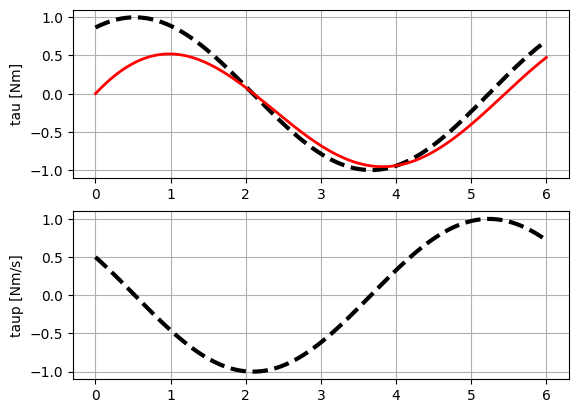

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd
import math

# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"

print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    return out_states


# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations

torque_ref = np.sin(time_vector + math.pi/3)
print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
torquep_ref = np.cos(time_vector + math.pi/3)
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))
# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

## Sinal de entrada sendo constante

Starting motor simulation.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller: kc1 = 1
Max ref: 0.5
Min ref: 0.5
Max ref: 0.0
Min ref: 0.0

--- SIMULATION CONFIG. ---

Simulation time: 10.0 sec
Time granulatiry: 1.000001000001e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 7.893277883529663 sec.

--- SIMULATION Finished. ---



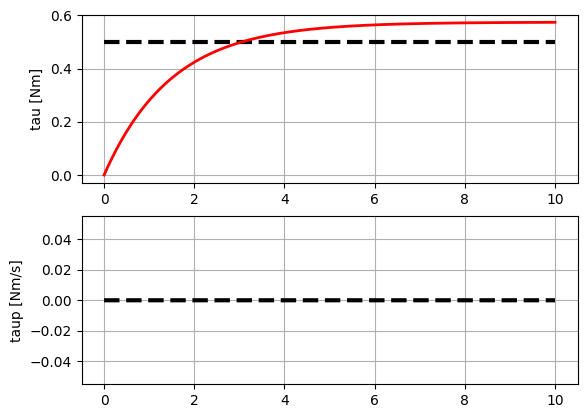

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd
import math

# Simulation parametrs
tf = 10.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"

print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    return out_states


# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations
constant_torque_value = 0.5
torque_ref = np.full_like(time_vector, constant_torque_value)
torquep_ref = np.full_like(time_vector, 0.0)


print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))
# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

## Sinal de entrada sendo rampa

In [3]:
def ramp(x):
    return np.maximum(0, x)

Starting motor simulation.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller: kc1 = 1
Max ref: 6.0
Min ref: 0.0
Max ref: 1.0
Min ref: 0.0

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 4.474736213684082 sec.

--- SIMULATION Finished. ---



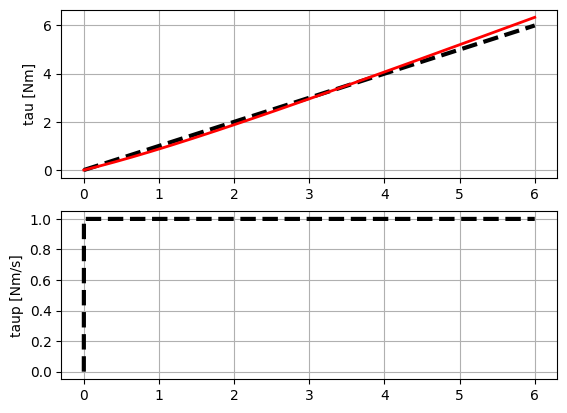

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd
import math

# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_a_with_error_wtf2"
print("Starting motor simulation.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
# Motor Controller (Control1)
k_c1 = 1

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller: kc1 = {}".format(k_c1))

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    # taup + a*k*tau = k*u
    # With the change: x1_m = tau (x1_motor)
    dx1_m = -a*k*x1_m + k*u
    y1_m = x1_m
    return dx1_m

def motor_controller(tau, tau_ref, taup_ref):
    # Non-Linear control for DC Motor following Dyn ecs: taup + a*k*tau = k*u
    # The controller returns dc_volts
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)


# The following function puts all ecuations together
def connected_systems_model(states, t, tau_ref, taup_ref):
    # Input values. Check this with the out_states list
    x1_m, _ = states

    # Compute motor controller
    dc_volts = motor_controller(x1_m, tau_ref, taup_ref)
    # Compute motor torque
    taup = dc_motor_model(x1_m, dc_volts)

    # Output
    out_states = [taup, dc_volts]
    return out_states


# Initial conditions
states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1) # number of time points

# time span for the simulation, cycle every tf/n seconds
time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

# Reference signal and its differentiations
torque_ref = ramp(time_vector)
torquep_ref = np.where(time_vector > 0, 1.0, 0.0)

print("Max ref: {}".format(max(torque_ref)))
print("Min ref: {}".format(min(torque_ref)))
print("Max ref: {}".format(max(torquep_ref)))
print("Min ref: {}".format(min(torquep_ref)))
# Output arrays
states = np.zeros( (n-1, len(states0)) ) # States for each timestep

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
# Simulate with ODEINT
t_counter = 0
for i in range(n-1):
    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(torque_ref[i], torquep_ref[i]))
    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

if save_data:
    print("Saving simulation data...")
    sim_df = pd.DataFrame(states)
    sim_df = sim_df.transpose()
    sim_df.rename({0: 'tau', 1: 'tau_ref', 2: 'taup_ref',
                   3: 'dc_volts'}, inplace=True)
    sim_df.to_csv('sim_data/ex4_motor_control.csv')

# Plot results
# States are: tau, tau_ref, taup_ref, dc_volts
plt.rcParams['axes.grid'] = True
plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3)
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2)
plt.ylabel('tau [Nm]')
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3)
plt.ylabel('taup [Nm/s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

## Alterando o controlador para um PID

Starting motor simulation with PID controller.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller PID: Kp=20.0, Ki=15.0, Kd=0.5

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 4.397964000701904 sec.

--- SIMULATION Finished. ---



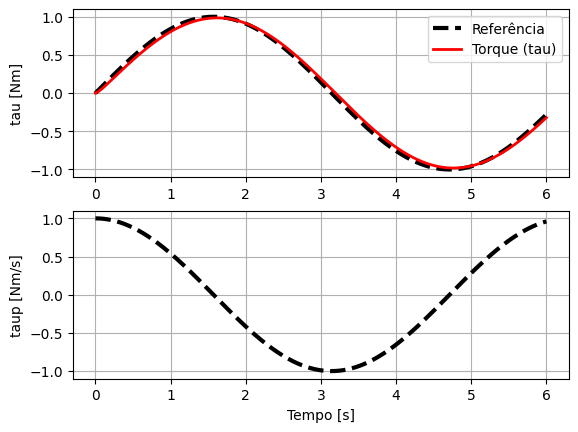

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd

# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_PID"

print("Starting motor simulation with PID controller.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
err_2 = []
# Motor Controller (PID)
Kp = 20.0
Ki = 15.0
Kd = 0.5

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller PID: Kp={}, Ki={}, Kd={}".format(Kp, Ki, Kd))

SC_k_2 = []

# Define models
def dc_motor_model(x1_m, u):
    # DC motor model:
    dx1_m = -(a+a_model_error)*(k+k_model_error)*x1_m + (k+k_model_error)*u

    SC_k_2.append(u)

    y1_m = x1_m
    return dx1_m

def connected_systems_model(states, t, dc_volts):
    # Valores de entrada. O primeiro estado é o torque (tau)
    x1_m, _ = states

    # Calcula o torque do motor
    taup = dc_motor_model(x1_m, dc_volts)

    # Saída
    # out_states = [taup, dc_volts]
    out_states = [taup, 0.0]
    return out_states

states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1)

time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

pid_controller = PIDController(Kp, Ki, Kd, t_sim_step, err_2)

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

states_2 = np.zeros( (n-1, len(states0)) )

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
t_counter = 0

current_tau = states0[0]

for i in range(n-1):
    tau_ref_i = torque_ref[i]

    dc_volts = pid_controller.calculate_control_action(tau_ref_i, current_tau)

    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(dc_volts,))

    states0 = out_states[-1,:]
    states[i] = out_states[-1,:]
    current_tau = states0[0]

    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

# Plot results
plt.rcParams['axes.grid'] = True
plt.figure()

# Plot do Torque (Tau)
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3, label='Referência')
plt.plot(time_vector[:-1],states[:,0],'r',linewidth=2, label='Torque (tau)')
plt.ylabel('tau [Nm]')
plt.legend()

# Plot da Tensão CC (dc_volts) - Apenas plotamos a referência aqui,
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3, label='Tau_p Ref')
plt.ylabel('taup [Nm/s]')
plt.xlabel('Tempo [s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()

# Aula 2

- Desenvolver sistema de controle baseado em erro.
- Métricas a serem consideradas são
- IAE/MAE
- ITAE
- ISE/MSE
- Índice de Goodhart

In [8]:
class Metrics:
  def __init__(self, err: list):
    self.err = err

  def mae(self, err: list) -> float:
      return np.mean(np.abs(err))

  def itae(self, err: list, t: np.ndarray) -> float:
      return (np.mean(np.abs(err) * t))

  def mse(self, err: list) -> float:
      return np.mean(np.square(err))

  def _epsilon1(self, SC_k: list) -> float:
      return np.mean(SC_k)

  def _epsilon2(self, SC_k: list, eps_1) -> float:
      result = []
      for i in range(len(SC_k)):
        result.append(np.square(SC_k[i] - eps_1))
      return np.mean(result)

  def _epsilon3(self, err: list) -> float:
      return self.mse(err)

  def goodhart_index(self, c1: float, c2: float, c3: float, SC_k: list)-> float:
      first_idx = c1 * self._epsilon1(SC_k)
      second_idx = c2 * self._epsilon2(SC_k, self._epsilon1(SC_k))
      third_idx = c3 * self._epsilon3(self.err)

      bom_coracao = first_idx + second_idx + third_idx
      return bom_coracao

## Pegando valores das métricas

In [9]:
metrics_PID = Metrics(err_2)
mae_PID = metrics_PID.mae(err_2)
t = time_vector[:-1]
itae_PID = metrics_PID.itae(err_2, t)
mse_PID = metrics_PID.mse(err_2)
goodhart_index_PID = metrics_PID.goodhart_index(0.33, 0.33, 0.34, SC_k_2)
print("\n---METRICS PID---\n")
print("MAE PID: {}".format(mae_PID))
print("ITAE PID: {}".format(itae_PID))
print("MSE PID: {}".format(mse_PID))
print("Goodhart Index PID: {}".format(goodhart_index_PID))


---METRICS PID---

MAE PID: 0.031357747458803396
ITAE PID: 0.09108330581459186
MSE PID: 0.0012279075804254337
Goodhart Index PID: 0.12961989355549092


Comparação dos dois controladores com o erro

In [10]:


metrics_PID = {
    "MAE": mae_PID,
    "ITAE": itae_PID,
    "MSE": mse_PID,
    "Goodhart": goodhart_index_PID
}


metrics_ORIGINAL = {
    "MAE": mae_ORIGINAL,
    "ITAE": itae_ORIGINAL,
    "MSE": mse_ORIGINAL,
    "Goodhart": goodhart_index_ORIGINAL
}

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(time_vector[:-1], torque_ref[:-1], 'k--', label='Referência', linewidth=2)
axs[0].plot(time_vector[:-1], states_1[:,0], 'b', label='Controlador 1')
axs[0].plot(time_vector[:-1], states_2[:,0], 'r', label='Controlador 2 (PID)')
axs[0].set_ylabel('Torque [Nm]')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time_vector[:-1], err_1, 'b', label='Erro Ctrl 1')
axs[1].plot(time_vector[:-1], err_2, 'r', label='Erro Ctrl 2 (PID)')
axs[1].set_ylabel('Erro [Nm]')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time_vector[:-1], SC_k_1, 'b', label='Tensão Ctrl 1', alpha=0.7)
axs[2].plot(time_vector[:-1], SC_k_2, 'r', label='Tensão Ctrl 2 (PID)', alpha=0.7)
axs[2].set_ylabel('Tensão [V]')
axs[2].set_xlabel('Tempo [s]')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print(f"{'Métrica':<15} | {'Controlador ORIGINAL':<15} | {'Controlador (PID)':<15}")
print("-" * 50)
for k in metrics_ORIGINAL:
    print(f"{k:<15} | {metrics_ORIGINAL[k]:.6f}        | {metrics_PID[k]:.6f}")

NameError: name 'mae_ORIGINAL' is not defined

# Algoritmo genético

# teste

Starting motor simulation with PID controller.

--- PARAMETERS --- 
 
Motor Parameters: a = 1, k = 1
Motor Induced Model Errors: a_error = 0.1, k_error = 0.3
Motor Controller PID: Kp=20.0, Ki=15.0, Kd=0.5

--- SIMULATION CONFIG. ---

Simulation time: 6.0 sec
Time granulatiry: 1.0000016666694445e-05
Initial states: [0, 0]

--- SIMULATION Begins ---

Simulation at 0%
Simulation at 10%
Simulation at 20%
Simulation at 30%
Simulation at 40%
Simulation at 50%
Simulation at 60%
Simulation at 70%
Simulation at 80%
Simulation at 90%
Simulation at 100%

Elapsed time: 4.346630811691284 sec.

--- SIMULATION Finished. ---



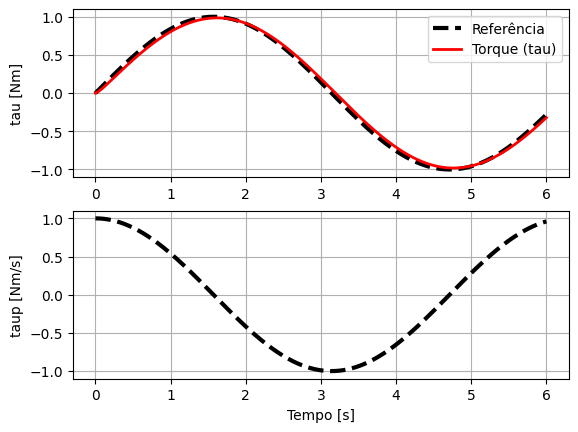

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
import time
import pandas as pd

# Simulation parametrs
tf = 6.0  # final time
ts_ms = 0.01  # 0.001 = 1us, 1 = 1ms
save_data = False  # Attention: CSV file can be very big
show_fig = True
save_fig = False  # If False, figure is showed but not saved
title = "motor_control_PID"

print("Starting motor simulation with PID controller.")

# Models Parameters
# Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3
err_2 = []
# Motor Controller (PID)
Kp = 20.0
Ki = 15.0
Kd = 0.5

print("\n--- PARAMETERS --- \n ")
print("Motor Parameters: a = {}, k = {}".format(a, k))
print("Motor Induced Model Errors: a_error = {}, k_error = {}".
      format(a_model_error, k_model_error))
print("Motor Controller PID: Kp={}, Ki={}, Kd={}".format(Kp, Ki, Kd))

SC_k_2 = []

def dc_motor_model(x1_m, u):
    # DC motor model:
    dx1_m = -(a+a_model_error)*(k+k_model_error)*x1_m + (k+k_model_error)*u

    y1_m = x1_m
    return dx1_m

def connected_systems_model(states, t, dc_volts):
    # Valores de entrada. O primeiro estado é o torque (tau)
    x1_m, _ = states

    # Calcula o torque do motor
    taup = dc_motor_model(x1_m, dc_volts)

    # Saída
    # out_states = [taup, dc_volts]
    out_states = [taup, 0.0]
    return out_states

states0 = [0, 0]
n = int((1 / (ts_ms / 1000.0))*tf + 1)

time_vector = np.linspace(0,tf,n)
t_sim_step = time_vector[1] - time_vector[0]

pid_controller = PIDController(Kp, Ki, Kd, t_sim_step, err_2)

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

states_2 = np.zeros( (n-1, len(states0)) )

print("\n--- SIMULATION CONFIG. ---\n")
print("Simulation time: {} sec".format(tf))
print("Time granulatiry: {}".format(t_sim_step))
print("Initial states: {}".format(states0))

print("\n--- SIMULATION Begins ---\n")

initial_time = time.time()
t_counter = 0

current_tau = states0[0]

for i in range(n-1):
    tau_ref_i = torque_ref[i]

    dc_volts = pid_controller.calculate_control_action(tau_ref_i, current_tau)
    SC_k_2.append(dc_volts)

    out_states = odeint(connected_systems_model, states0, [0.0, tf/n],
                        args=(dc_volts,))

    states0 = out_states[-1,:]
    states_2[i] = out_states[-1,:]
    current_tau = states0[0]

    if i >= t_counter * int((n-1)/10):
        print("Simulation at {}%".format(t_counter*10))
        t_counter += 1

elapsed_time = time.time() - initial_time
print("\nElapsed time: {} sec.".format(elapsed_time))
print("\n--- SIMULATION Finished. ---\n")

# Plot results
plt.rcParams['axes.grid'] = True
plt.figure()

# Plot do Torque (Tau)
plt.subplot(2,1,1)
plt.plot(time_vector[:-1],torque_ref[:-1],'k--',linewidth=3, label='Referência')
plt.plot(time_vector[:-1],states_2[:,0],'r',linewidth=2, label='Torque (tau)')
plt.ylabel('tau [Nm]')
plt.legend()

# Plot da Tensão CC (dc_volts) - Apenas plotamos a referência aqui,
plt.subplot(2,1,2)
plt.plot(time_vector[:-1],torquep_ref[:-1],'k--',linewidth=3, label='Tau_p Ref')
plt.ylabel('taup [Nm/s]')
plt.xlabel('Tempo [s]')

if save_fig:
    figname = "pictures/" + title + ".png"
    plt.savefig(figname)
if show_fig:
    plt.show()


Iniciando Otimização PID via AG (Minimizando Goodhart Index)...
Gen 1: Melhor Score = 0.2758 | PID: [Kp=29.49, Ki=2.55, Kd=0.18]
Gen 2: Melhor Score = 0.2758 | PID: [Kp=29.49, Ki=2.55, Kd=0.18]
Gen 3: Melhor Score = 0.2758 | PID: [Kp=29.49, Ki=2.55, Kd=0.18]
Gen 4: Melhor Score = 0.2758 | PID: [Kp=29.49, Ki=2.55, Kd=0.18]
Gen 5: Melhor Score = 0.2750 | PID: [Kp=30.54, Ki=0.96, Kd=0.22]
Gen 6: Melhor Score = 0.2750 | PID: [Kp=30.54, Ki=0.96, Kd=0.22]
Gen 7: Melhor Score = 0.2750 | PID: [Kp=30.54, Ki=0.96, Kd=0.22]
Gen 8: Melhor Score = 0.2748 | PID: [Kp=30.19, Ki=1.10, Kd=0.26]
Gen 9: Melhor Score = 0.2747 | PID: [Kp=30.51, Ki=0.64, Kd=0.22]
Gen 10: Melhor Score = 0.2747 | PID: [Kp=30.51, Ki=0.64, Kd=0.22]

PID Otimizado: Kp=30.5114, Ki=0.6395, Kd=0.2153


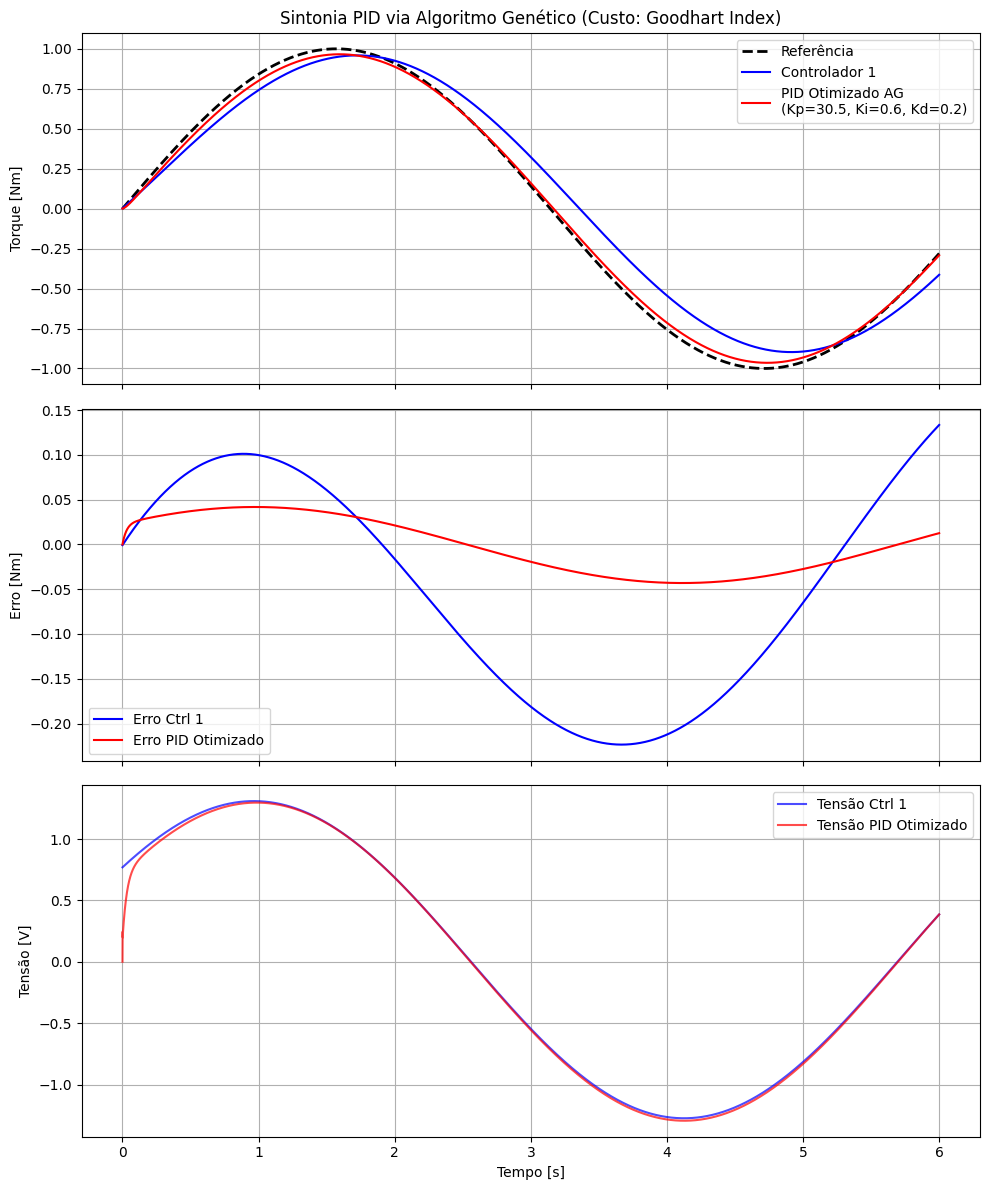

Métrica         | Controlador 1   | PID (AG)       
--------------------------------------------------
MAE             | 0.108590        | 0.027321
ITAE            | 0.355119        | 0.075094
MSE             | 0.016314        | 0.000923
Goodhart        | 0.285989        | 0.274685


In [12]:
# --- CONFIGURAÇÃO DA SIMULAÇÃO (GLOBAL) ---
tf = 6.0
ts_ms = 1.0
n = int((1 / (ts_ms / 1000.0))*tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3

# --- MODELOS ---
def model_2(states, t, u):
    x1_m, _ = states
    dx1_m = -(a+a_model_error)*(k+k_model_error)*x1_m + (k+k_model_error)*u
    return [dx1_m, 0.0]

# --- IMPLEMENTAÇÃO DO ALGORITMO GENÉTICO ---

def run_simulation(kp, ki, kd):
    """
    Roda a simulação para um conjunto PID específico.
    Retorna histórico de Erro e Esforço de Controle.
    """
    local_err = []
    pid = PIDController(kp, ki, kd, t_sim_step, local_err)
    local_SC_k = []
    curr_state = [0, 0] # Reset state

    for i in range(n-1):
        ref = torque_ref[i]
        meas = curr_state[0]

        u = pid.calculate_control_action(ref, meas)

        # Opcional: Adicionar saturação para realismo (evita valores infinitos no AG)
        u = np.clip(u, -200, 200)

        local_SC_k.append(u)

        out = odeint(model_2, curr_state, [0, t_sim_step], args=(u,))
        curr_state = out[-1, :]

    return local_err, local_SC_k

def fitness_function(individual):
    kp, ki, kd = individual

    # Restrição: Ganhos não podem ser negativos
    if kp < 0 or ki < 0 or kd < 0:
        return 1e9 # Penalidade alta (morte)

    err_hist, u_hist = run_simulation(kp, ki, kd)

    m = Metrics(err_hist)

    # Pesos definidos no seu exemplo: 0.33, 0.33, 0.34
    # O Goodhart tenta equilibrar Esforço Médio, Variância do Esforço e Erro Quadrático
    score = m.goodhart_index(0.33, 0.33, 0.34, u_hist)

    # Se o sistema explodir (NaN ou Inf), penalizar
    if np.isnan(score) or np.isinf(score):
        return 1e9

    return score

def genetic_algorithm():
    # Parâmetros do AG
    POP_SIZE = 20
    GENERATIONS = 10
    MUTATION_RATE = 0.2
    MUTATION_SCALE = 1.0 # Quanto o valor muda na mutação

    # Inicialização da População (Valores aleatórios entre 0 e 50)
    population = [[random.uniform(0, 50), random.uniform(0, 50), random.uniform(0, 10)] for _ in range(POP_SIZE)]

    print(f"Iniciando Otimização PID via AG (Minimizando Goodhart Index)...")

    best_global_ind = None
    best_global_score = float('inf')

    for gen in range(GENERATIONS):
        scored_pop = []

        # Avaliação
        for ind in population:
            score = fitness_function(ind)
            scored_pop.append((ind, score))

        # Ordenar (Menor score é melhor)
        scored_pop.sort(key=lambda x: x[1])

        best_gen_ind = scored_pop[0][0]
        best_gen_score = scored_pop[0][1]

        if best_gen_score < best_global_score:
            best_global_score = best_gen_score
            best_global_ind = best_gen_ind

        print(f"Gen {gen+1}: Melhor Score = {best_gen_score:.4f} | PID: [Kp={best_gen_ind[0]:.2f}, Ki={best_gen_ind[1]:.2f}, Kd={best_gen_ind[2]:.2f}]")

        # Seleção (Top 50%)
        parents = [x[0] for x in scored_pop[:POP_SIZE//2]]

        # Reprodução
        new_pop = []
        # Elitismo (mantém o melhor)
        new_pop.append(best_gen_ind)

        while len(new_pop) < POP_SIZE:
            p1 = random.choice(parents)
            p2 = random.choice(parents)

            # Crossover (Média ponderada aleatória)
            alpha = random.random()
            child = [alpha*g1 + (1-alpha)*g2 for g1, g2 in zip(p1, p2)]

            # Mutação
            if random.random() < MUTATION_RATE:
                idx = random.randint(0, 2)
                child[idx] += random.gauss(0, MUTATION_SCALE)
                # Garante não negativo
                child[idx] = max(0.0, child[idx])

            new_pop.append(child)

        population = new_pop

    return best_global_ind

# --- EXECUÇÃO DO AG ---
best_pid = genetic_algorithm()
Kp_opt, Ki_opt, Kd_opt = best_pid
print(f"\nPID Otimizado: Kp={Kp_opt:.4f}, Ki={Ki_opt:.4f}, Kd={Kd_opt:.4f}")

# --- EXECUÇÃO DAS SIMULAÇÕES FINAIS PARA PLOTAGEM ---

# 1. Executa o Controlador 1 (Fixo do seu código original)
k_c1 = 1
SC_k_1 = []
err_1 = []
states_1 = np.zeros((n-1, 2))
curr_state = [0, 0] # Reset

def motor_controller_1(tau, tau_ref, taup_ref):
    v = taup_ref - k_c1*(tau - tau_ref)
    return (a+a_model_error)*tau + v/(k+k_model_error)

def model_1(states, t, tau_ref, taup_ref):
    x1_m, _ = states
    dc_volts = motor_controller_1(x1_m, tau_ref, taup_ref)
    dx1_m = -a*k*x1_m + k*dc_volts
    return [dx1_m, dc_volts]

for i in range(n-1):
    u = motor_controller_1(curr_state[0], torque_ref[i], torquep_ref[i])
    SC_k_1.append(u)
    out = odeint(model_1, curr_state, [0, t_sim_step], args=(torque_ref[i], torquep_ref[i]))
    curr_state = out[-1, :]
    states_1[i] = curr_state
    err_1.append(torque_ref[i] - states_1[i, 0])

# 2. Executa o Controlador 2 com o PID OTIMIZADO pelo AG
# Note que estamos usando a função wrapper criada para garantir consistência
err_2, SC_k_2 = run_simulation(Kp_opt, Ki_opt, Kd_opt)

# Para plotagem, precisamos recalcular os estados (a função run_simulation só retorna erro e u)
# Vou refazer o loop aqui explicitamente para preencher states_2 para o gráfico
pid_final_err = []
pid_final = PIDController(Kp_opt, Ki_opt, Kd_opt, t_sim_step, pid_final_err)
states_2 = np.zeros((n-1, 2))
curr_state = [0, 0]
for i in range(n-1):
    ref = torque_ref[i]
    meas = curr_state[0]
    u = pid_final.calculate_control_action(ref, meas)
    u = np.clip(u, -200, 200) # Mesma saturação usada na otimização
    out = odeint(model_2, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_2[i] = curr_state


# --- CÁLCULO DE MÉTRICAS E PLOTAGEM ---

m1 = Metrics(err_1)
metrics1 = {
    "MAE": m1.mae(m1.err),
    "ITAE": m1.itae(m1.err, time_vector[:-1]),
    "MSE": m1.mse(m1.err),
    "Goodhart": m1.goodhart_index(0.33, 0.33, 0.34, SC_k_1)
}

m2 = Metrics(err_2)
metrics2 = {
    "MAE": m2.mae(m2.err),
    "ITAE": m2.itae(m2.err, time_vector[:-1]),
    "MSE": m2.mse(m2.err),
    "Goodhart": m2.goodhart_index(0.33, 0.33, 0.34, SC_k_2)
}

# Gráficos
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(time_vector[:-1], torque_ref[:-1], 'k--', label='Referência', linewidth=2)
axs[0].plot(time_vector[:-1], states_1[:,0], 'b', label='Controlador 1')
axs[0].plot(time_vector[:-1], states_2[:,0], 'r', label=f'PID Otimizado AG\n(Kp={Kp_opt:.1f}, Ki={Ki_opt:.1f}, Kd={Kd_opt:.1f})')
axs[0].set_ylabel('Torque [Nm]')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Sintonia PID via Algoritmo Genético (Custo: Goodhart Index)')

axs[1].plot(time_vector[:-1], err_1, 'b', label='Erro Ctrl 1')
axs[1].plot(time_vector[:-1], err_2, 'r', label='Erro PID Otimizado')
axs[1].set_ylabel('Erro [Nm]')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time_vector[:-1], SC_k_1, 'b', label='Tensão Ctrl 1', alpha=0.7)
axs[2].plot(time_vector[:-1], SC_k_2, 'r', label='Tensão PID Otimizado', alpha=0.7)
axs[2].set_ylabel('Tensão [V]')
axs[2].set_xlabel('Tempo [s]')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

print(f"{'Métrica':<15} | {'Controlador 1':<15} | {'PID (AG)':<15}")
print("-" * 50)
for k in metrics1:
    print(f"{k:<15} | {metrics1[k]:.6f}        | {metrics2[k]:.6f}")

# Método dos Poliedros Flexíveis

Iniciando Otimização PID via Poliedros Flexíveis (Nelder-Mead)...
Iter 1: Score=0.0350 | PID: [16.   5.   0.1]
Iter 2: Score=0.0350 | PID: [16.   5.   0.1]
Iter 3: Score=0.0350 | PID: [16.   5.   0.1]
Iter 4: Score=0.0350 | PID: [16.   5.   0.1]
Iter 5: Score=0.0311 | PID: [18.63  4.2   0.55]
Iter 6: Score=0.0241 | PID: [24.74  4.27  0.26]
Iter 7: Score=0.0235 | PID: [24.91  1.26  0.15]
Iter 8: Score=0.0201 | PID: [29.52  1.48  0.54]
Iter 9: Score=0.0174 | PID: [34.16  0.47  0.08]
Iter 10: Score=0.0174 | PID: [34.16  0.47  0.08]
Iter 11: Score=0.0170 | PID: [35.63  1.82  0.43]
Iter 12: Score=0.0170 | PID: [35.63  1.82  0.43]
Iter 13: Score=0.0163 | PID: [3.708e+01 1.350e+00 1.000e-02]
Iter 14: Score=0.0147 | PID: [4.112e+01 4.700e-01 4.000e-02]
Iter 15: Score=0.0147 | PID: [4.112e+01 4.700e-01 4.000e-02]
Iter 16: Score=0.0147 | PID: [4.112e+01 4.700e-01 4.000e-02]
Iter 17: Score=0.0136 | PID: [46.5   1.26  0.53]
Iter 18: Score=0.0117 | PID: [53.75  0.6   0.29]
Iter 19: Score=0.0117 | P

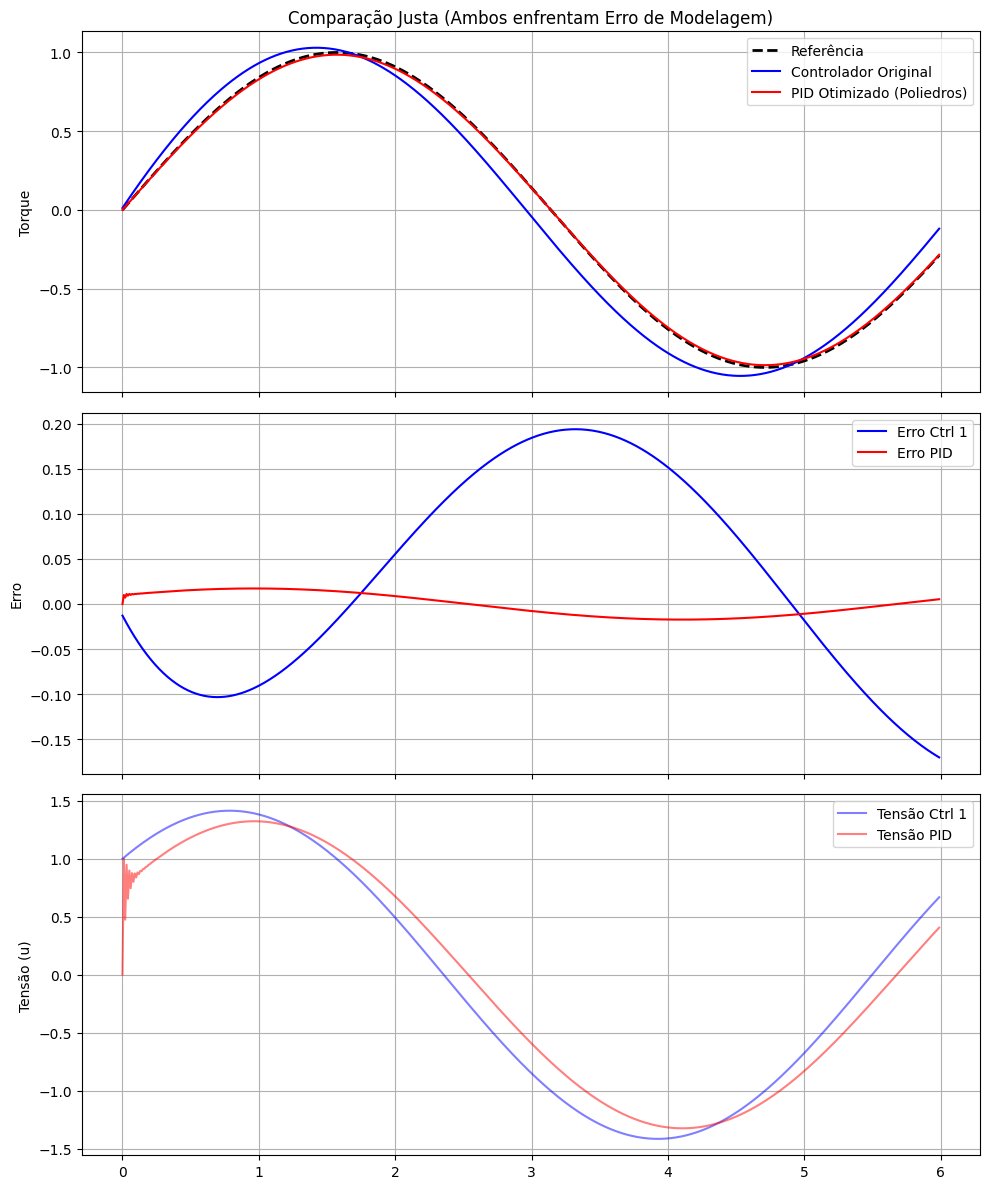

Goodhart Index Final -> Original: 0.0715 | PID (Poliedros): 0.0087


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time


class PIDController:
    def __init__(self, Kp, Ki, Kd, dt, err_storage=None):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.dt = dt
        self.integral = 0.0
        self.prev_error = 0.0
        self.err_storage = err_storage

    def calculate_control_action(self, setpoint, measured_value):
        error = setpoint - measured_value
        self.integral += error * self.dt
        derivative = (error - self.prev_error) / self.dt
        output = (self.Kp * error) + (self.Ki * self.integral) + (self.Kd * derivative)
        self.prev_error = error
        if self.err_storage is not None:
            self.err_storage.append(error)
        return output

class Metrics:
    def __init__(self, error_history):
        self.error_history = np.array(error_history)

    def goodhart_index(self, w1, w2, w3, control_effort):
        mse = np.mean(self.error_history**2)
        max_err = np.max(np.abs(self.error_history)) if len(self.error_history) > 0 else 0
        mean_effort = np.mean(np.abs(control_effort)) if len(control_effort) > 0 else 0
        return (w1 * mse) + (w2 * max_err) + (w3 * mean_effort * 0.01)

tf = 6.0
ts_ms = 10.0
n = int((1 / (ts_ms / 1000.0))*tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

a = 1.0
k = 1.0
a_model_error = 0.1
k_model_error = 0.3

def motor_physics_real(states, t, u):
    x1_m, _ = states
    dx1_m = -(a + a_model_error)*(k + k_model_error)*x1_m + (k + k_model_error)*u
    return [dx1_m, 0.0]

def run_simulation(kp, ki, kd):
    local_err = []
    pid = PIDController(kp, ki, kd, t_sim_step, local_err)
    local_SC_k = []
    curr_state = [0.0, 0.0]

    for i in range(n-1):
        ref = torque_ref[i]
        meas = curr_state[0]

        u = pid.calculate_control_action(ref, meas)
        u = np.clip(u, -200, 200)

        local_SC_k.append(u)

        out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
        curr_state = out[-1, :]

    return local_err, local_SC_k

def fitness_function(individual):
    kp, ki, kd = individual

    if kp < 0 or ki < 0 or kd < 0: return 1e9

    try:
        err_hist, u_hist = run_simulation(kp, ki, kd)
        m = Metrics(err_hist)

        score = m.goodhart_index(0.4, 0.4, 0.2, u_hist)

        if np.isnan(score) or np.isinf(score): return 1e9
        return score
    except:
        return 1e9

def flexible_polyhedron_method():
    alpha = 1.0
    gamma = 2.0
    rho = 0.5
    sigma = 0.5

    max_iter = 30
    tol = 1e-4

    x0 = np.array([10.0, 5.0, 0.1])

    simplex = [x0]
    for i in range(len(x0)):
        x = np.array(x0, copy=True)
        x[i] = x[i] * 1.5 + 1.0
        simplex.append(x)

    print(f"Iniciando Otimização PID via Poliedros Flexíveis (Nelder-Mead)...")

    for k in range(max_iter):
        simplex.sort(key=lambda x: fitness_function(x))
        best = simplex[0]
        worst = simplex[-1]
        best_score = fitness_function(best)

        print(f"Iter {k+1}: Score={best_score:.4f} | PID: {np.round(best, 2)}")

        if np.linalg.norm(simplex[0] - simplex[-1]) < tol:
            break

        centroid = np.mean(simplex[:-1], axis=0)

        xr = centroid + alpha * (centroid - worst)
        score_r = fitness_function(xr)

        if fitness_function(best) <= score_r < fitness_function(simplex[-2]):
            simplex[-1] = xr

        elif score_r < fitness_function(best):
            xe = centroid + gamma * (xr - centroid)
            if fitness_function(xe) < score_r:
                simplex[-1] = xe
            else:
                simplex[-1] = xr

        else:
            xc = centroid + rho * (worst - centroid)
            score_c = fitness_function(xc)
            if score_c < fitness_function(worst):
                simplex[-1] = xc
            else:
                for i in range(1, len(simplex)):
                    simplex[i] = best + sigma * (simplex[i] - best)

    return simplex[0]

best_pid = flexible_polyhedron_method()
Kp_opt, Ki_opt, Kd_opt = best_pid

print(f"\n--- Otimização Concluída ---")
print(f"Melhores Ganhos: Kp={Kp_opt:.4f}, Ki={Ki_opt:.4f}, Kd={Kd_opt:.4f}")

k_c1 = 1.0
SC_k_1 = []
err_1 = []
states_1 = np.zeros((n-1, 2))
curr_state = [0.0, 0.0]

def motor_controller_1(tau, tau_ref, taup_ref):
    v = taup_ref - k_c1*(tau - tau_ref)
    u = (a*tau + v)/k
    return u

for i in range(n-1):
    u = motor_controller_1(curr_state[0], torque_ref[i], torquep_ref[i])
    SC_k_1.append(u)
    out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_1[i] = curr_state
    err_1.append(torque_ref[i] - states_1[i, 0])

err_2, SC_k_2 = run_simulation(Kp_opt, Ki_opt, Kd_opt)

pid_final_plot = PIDController(Kp_opt, Ki_opt, Kd_opt, t_sim_step, [])
states_2 = np.zeros((n-1, 2))
curr_state = [0.0, 0.0]
for i in range(n-1):
    u = pid_final_plot.calculate_control_action(torque_ref[i], curr_state[0])
    u = np.clip(u, -200, 200)
    out = odeint(motor_physics_real, curr_state, [0, t_sim_step], args=(u,))
    curr_state = out[-1, :]
    states_2[i] = curr_state

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axs[0].plot(time_vector[:-1], torque_ref[:-1], 'k--', label='Referência', linewidth=2)
axs[0].plot(time_vector[:-1], states_1[:,0], 'b', label='Controlador Original')
axs[0].plot(time_vector[:-1], states_2[:,0], 'r', label='PID Otimizado (Poliedros)')
axs[0].set_ylabel('Torque')
axs[0].legend()
axs[0].set_title('Comparação Justa (Ambos enfrentam Erro de Modelagem)')

axs[1].plot(time_vector[:-1], err_1, 'b', label='Erro Ctrl 1')
axs[1].plot(time_vector[:-1], err_2, 'r', label='Erro PID')
axs[1].set_ylabel('Erro')
axs[1].legend()

axs[2].plot(time_vector[:-1], SC_k_1, 'b', label='Tensão Ctrl 1', alpha=0.5)
axs[2].plot(time_vector[:-1], SC_k_2, 'r', label='Tensão PID', alpha=0.5)
axs[2].set_ylabel('Tensão (u)')
axs[2].legend()

plt.tight_layout()
plt.show()

m1 = Metrics(err_1)
gh1 = m1.goodhart_index(0.33, 0.33, 0.34, SC_k_1)
m2 = Metrics(err_2)
gh2 = m2.goodhart_index(0.33, 0.33, 0.34, SC_k_2)

print(f"Goodhart Index Final -> Original: {gh1:.4f} | PID (Poliedros): {gh2:.4f}")